# COVID-19 time-series analysis

Jonathan Stickel, 2020

This purpose of this notebook (and repository) is to make available a set of time-series
analyses of COVID-19 data. Data sources are:

- https://github.com/CSSEGISandData/COVID-19 (Johns Hopkins CSSE COVID-19 data)
- https://data.worldbank.org/indicator/sp.pop.totl (population data)

By default, the COVID-19 data is grabbed from the Johns Hopkins CSSE github.com repository. When using this notebook on a local machine, you may instead clone the repo to an adjent folder and keep it up-to-date (see arguments to `covid19_global` function).

Dependencies are:

- `numpy`
- `pandas`
- `matplotlib`
- `cvxopt`
- `scikit.datasmooth` (can be pip installed)

Also, `covid19ts` is part of this repository.

Click on this link for a web-based "live" notebook (it may take awhile to load, be patient):
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jjstickel/covid-19_ts_analysis.git/master?filepath=analyze_covide_time_series_notebook.ipynb)


In [1]:
# import modules
import numpy as np
# locally defined modules
from covid19ts import covid19_global, covid19_US
import covid_plots as cvp

# User input

Put up to 5 countries of interest in the `countries` list. Must be the same name used in the J-H global files, and (at the moment), it must be a single entry in the file (e.g., China has multiple entries and will cause an Exception). At the moment, `US` must be in the list because it is included in all of the US plots.

In [2]:
countries = ["US", "Italy", "Sweden", "Russia", "Brazil"]

Put up to 4 US locations (state, county, or city) in the `US_locs` list. Must be the same name used in the J-H US files. 

NOTE:  unfortunately, there are no pre-consolidated state data in the J-H data files. To get state data, I sum all the state entries, which, for for a few states, double-counts numbers when they are given as both county and city entries. The affect is muted when showing per-capita numbers, but cities will still have extra weighting over rural areas as a consequence.

In [3]:
US_locs = ["Colorado", "Wyoming", "South Dakota", "Wisconsin"]
# example list with a city location, `New York, New York`
#US_locs = ["Colorado", "California", "New York", "New York, New York"]

Read in Johns Hopkins CSSE COVID-19 timeseries data for the locations specified and perform these operations:
- normalize cases to be per capita
- smooth the cases data
- set time-zero for each location and shift elapsed time in days
- determine rates (i.e., the derivative) for cases

In [4]:
# global data
lmbd = 5e-5 # smoothing parameter, larger means more smooth
corona = covid19_global(countries, lmbd=lmbd)
# extract common variables for ease-of-use
mult = corona["mult"]
critlow = corona["critlow"]
nctry = len(countries)
dates = corona["dates"]
# US data
coronaUS = covid19_US(US_locs, lmbd=lmbd)
if not np.alltrue(corona["dates"] == coronaUS["dates"]):
    raise ValueError("the dates from the global and US files do not match")
nUSloc = len(US_locs)

*Estimate* "active" cases by presuming all confirmed cases have recovered or died in an aeverage number of days. Estimate of recovery time from:
- https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext
- https://towardsdatascience.com/visual-notes-from-singapores-first-100-fully-recovered-covid-19-patients-aad7f2e1d0a0

Also, *calculate* active cases by $a = c - d -r$ ($a=$ active, $c=$ confirmed, $d=$ deaths, and $r=$ recovered). Unfortunately, recovered data is really poor, and so this result is not very good and is no longer used in this notebook (although it is still calculated). Recovered data is not available for internal US locations, and so only an estimate of active cases is calculated.

In [5]:
rectime = 14 # days, 1 day = 1 data point -- you can change this number to see the affect on estimated acive cases
for country in countries:
    ctryd = corona[country]
    # calculate active cased based on JH data
    ctryd["acv_pc"] = ctryd["cnf_pc"] - ctryd["dth_pc"] - ctryd["rec_pc"]
    # estimate active cases based on an "average" recovery time
    ctryd["acvest_pc"] = ctryd["cnf_pc"].copy()
    ctryd["acvest_pc"][rectime:] = ctryd["acvest_pc"][rectime:] - ctryd["cnf_pc"][:-rectime]
    # recovered estimate -- not sure of the value of this...
    ctryd["recest_pc"] = ctryd["cnf_pc"] - ctryd["dth_pc"] - ctryd["acv_pc"]
for loc in US_locs:
    locd = coronaUS[loc]
    locd["acvest_pc"] = locd["cnf_pc"].copy()
    locd["acvest_pc"][rectime:] = locd["acvest_pc"][rectime:] - locd["cnf_pc"][:-rectime]

# Plotting

In [6]:
# plot setup
cvp.rcParams.update({'font.size': 14})
cvp.fw = 8
cvp.fh = 6
cvp.critlow_readable(corona) # provide convenient readable terms for time labeling

# Total cases (confirmed and deaths), not scaled

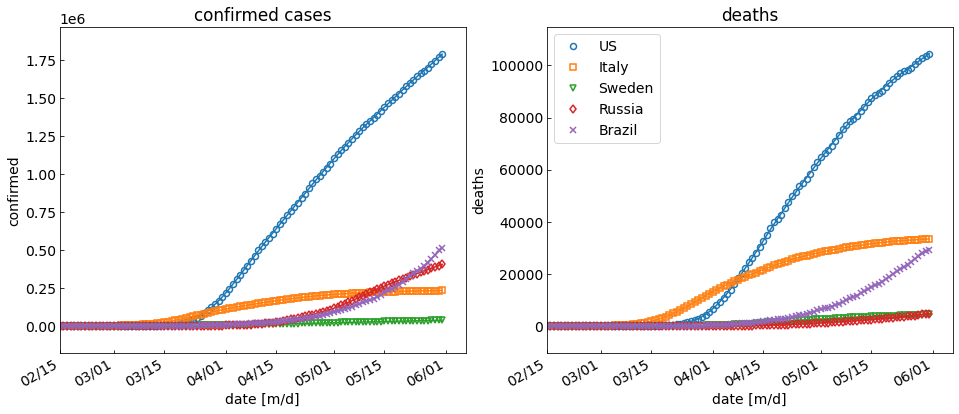

In [7]:
cvp.total_global_plot(corona)

Points are the data, lines are smoothing fit. I did not create this plot for US locations because the scale differences would render it not very useful.

# Per capita cases (confirmed and deaths) with elapsed number of days from a specified time zero as indicated in the x-axis

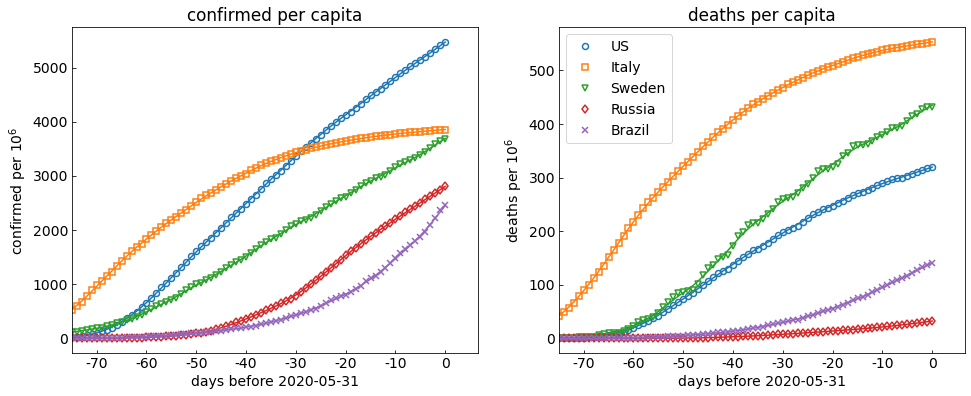

In [8]:
cvp.per_capita_global_plot(corona)

On a per capita basis, the US is actually fairing OK compared to some European countries (e.g., Spain and Italy). After the very early infections, growth is linear or sublinear for many countries, as will be shown in the subsequent plots of *growth rates*. Some discussion of exponential growth is discussed below (near the end).

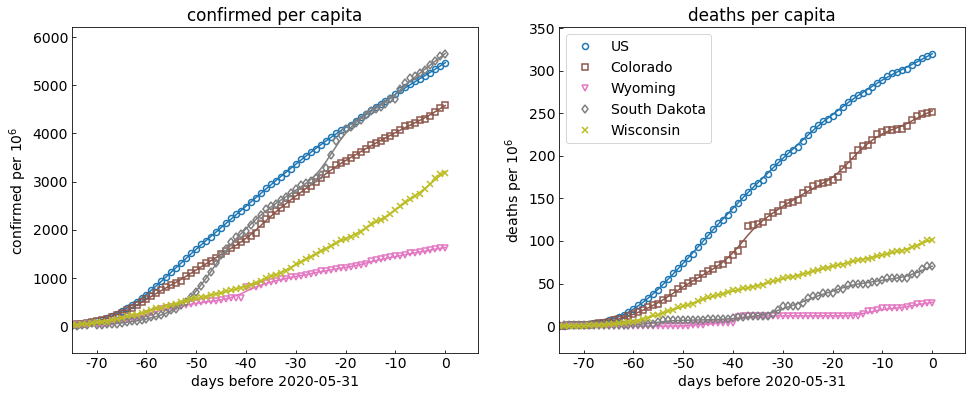

In [9]:
cvp.per_capita_US_plot(coronaUS, corona)

US local per capita data.

# Per capita growth rates (confirmed and deaths)

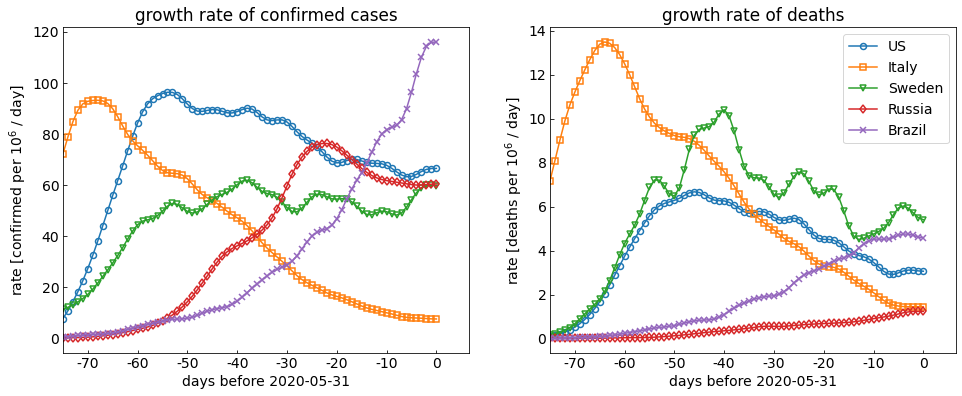

In [10]:
cvp.rate_global_plot(corona)

Growth rate is the derivative of the cases (i.e., instantaneous slope for each day). Rates for many countries have now decreased from their peak but have continued linear growth (i.e., a flat rate). 

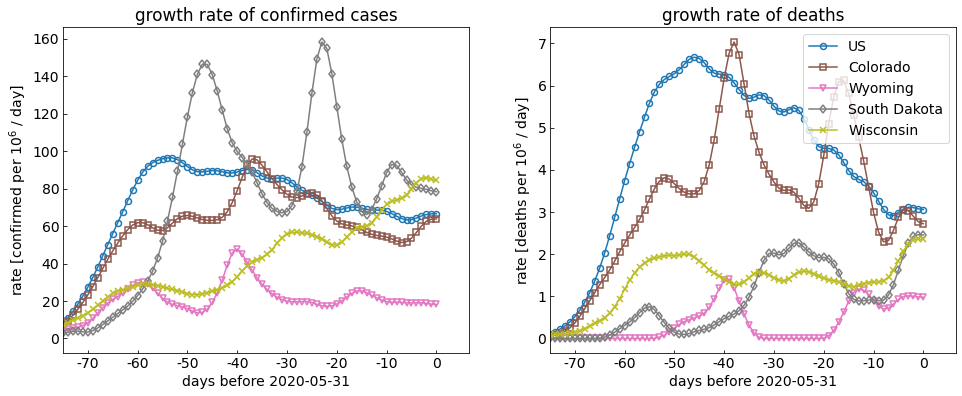

In [11]:
cvp.rate_US_plot(coronaUS, corona)

US local rate data.

# Active cases and case fatality ratio (CFR)

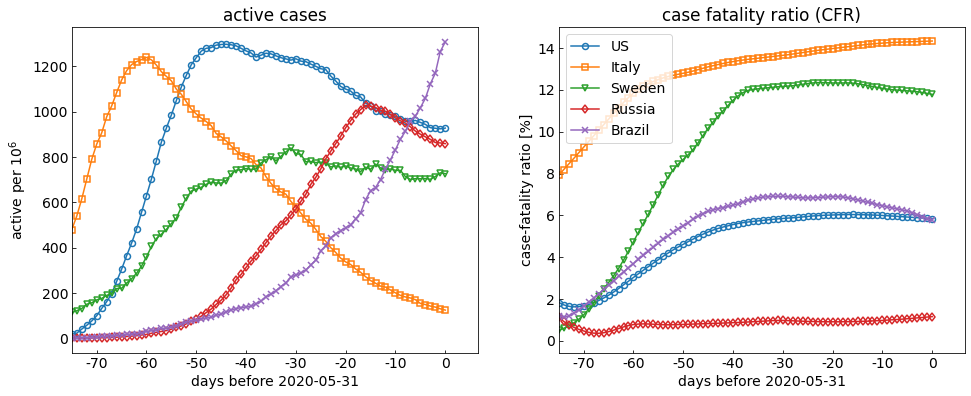

In [12]:
cvp.active_CFR_global_plot(corona)

Have we peaked? A curve of active cases help us answer this. Active cases can be calculated easily from data from confirmed, deaths, and recovered. Unfortunately, data for recovered cases is still not very good ([see here](https://www.cnn.com/2020/04/04/health/recovery-coronavirus-tracking-data-explainer/index.html)). For that reason, I estimate active cases by presuming that all confirmed cases are resolved (dead or recovered) in an average number of days (I estimated recovery time to be 14 days based on the links I provided above). By the estimated numbers, many countries have peaked (the US peaked in late April). Not surprising (to me), the rate of decline after the peak is much slower than the rate of increase before the peak, and so we will likely have relatively high numbers of active cases for many months, even years.
<!--The symbols are the calculated active cases and the lines are the estimated active cases. -->

The "case fatality ratio", or *CFR*, is an indication of how deadly a disease is. It is only an indication because it is limited by how many actual cases are measured and *confirmed*. Here, we see that the US is doing pretty good compared to other countries. There is a lot of talk about how we are not doing enough testing and that the confirmed numbers are low. Therefore, more testing would increase the denominator of the ratio and would make the CFR *even lower*. (Note: the CFR is commonly called the case fatality *rate*. The use of the word rate here is technically incorrect---rate refers to something changing over *time*. [More info here](https://ourworldindata.org/coronavirus?fbclid=IwAR3zOvtt7gqkhitoHJ_lXDr3eDeE_JPtfukpOkY94PSaBm_hmrMvWCXWFpg#what-do-we-know-about-the-risk-of-dying-from-covid-19))

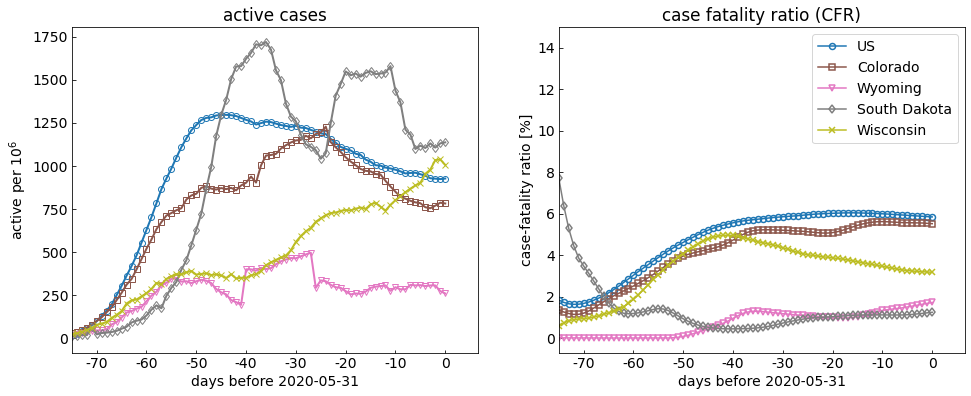

In [13]:
cvp.active_CFR_US_plot(coronaUS, corona)

US local active cases and CFR. <!--Active cases are only calculated by the estimation formula.-->

# Some other plots

Determine an exponential fit for the early part of the confirmed cases. As will be observed in the next plot, it does not take very long before the growth of cases slows from exponential. Initial doubling time is printed out after the code block.

In [14]:
# compute exponential fit to confirmed cases
def expfit(t, y):
    """
    fit data to exponential function
    """
    k, lna = np.polyfit(t, np.log(y), 1)
    return np.exp(lna), k

crithigh = 200*1e-6 # upper bound for exponential fit, for fitting confirmed
for country in countries:
    ctryd = corona[country]
    criteval = ctryd['cnf_pc'] < crithigh*mult
    idx0 = ctryd['idx0']
    idx1 = np.nonzero(criteval)[0][-1]
    a, k = expfit(ctryd['days'][idx0:idx1], ctryd['cnf_pc'][idx0:idx1])
    dt2in = np.log(2)/k
    print("initial doubling time for %s was %g days" % (country, dt2in))
    ctryd['a'] = a
    ctryd['k'] = k
    ctryd['dt2in'] = dt2in
    ctryd['cnf_expfit'] = a*np.exp(k*ctryd['days'])

initial doubling time for US was 2.09306 days
initial doubling time for Italy was 2.96734 days
initial doubling time for Sweden was 3.81468 days
initial doubling time for Russia was 4.34811 days
initial doubling time for Brazil was 6.25767 days


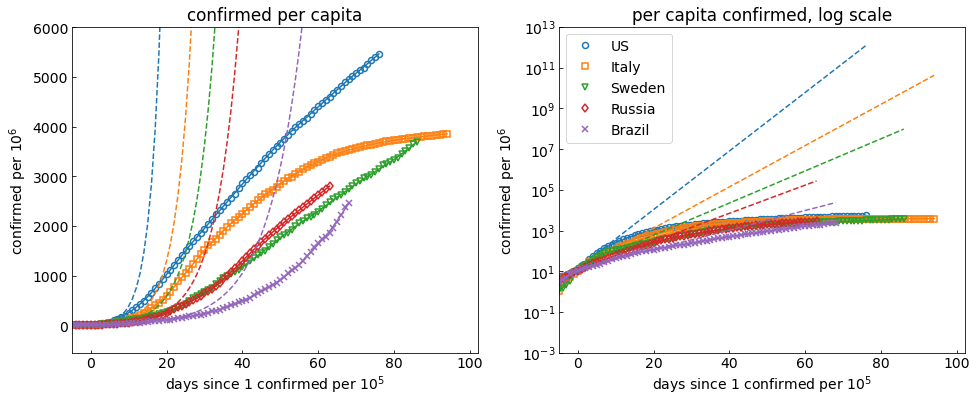

In [15]:
cvp.exp_fit_confirmed_plot(corona)

The dashed lines are exponential fits to the early-time confirmed cases. Despite all the talk about COVID-19 growing exponentially, exponential growth did not last very long at all. The right plot shows confirmed cases (per capita) on a semilog scale. A number of plots shown on the web are on a log scale like this, which would make sense if growth was truly exponential (the dashed lines are the exponential fits and appear linear here). Since growth is not exponential for long, I personally do not think using a log scale is appropriate. Most people without scientific training have a hard time interpreting log-scale figures.

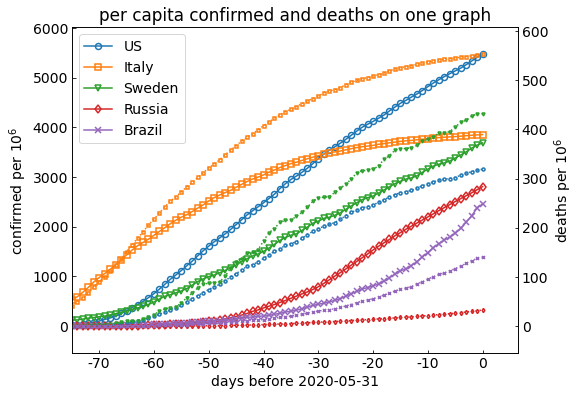

In [16]:
cvp.confirmed_deaths_simul_global_plot(corona)

This plot compares the trends of confirmed cases vs. deaths. Larger points and solid lines are confirmed, and smaller points and dotted lines are deaths.